# Import necessary libraries

In [29]:
import os
import pandas as pd
import numpy as np
import glob
import pickle
from pandas import DataFrame
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Merge all csv files of ODI matches

In [ ]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [ ]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "odi.csv", index=False)

# Import Dataset

In [8]:
df = pd.read_csv("odi.csv")

In [9]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
df.head(5)

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,bowler,runs_off_bat,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed
0,1000887,2016/17,2017-01-13,"Brisbane Cricket Ground, Woolloongabba",1,0.1,Australia,Pakistan,DA Warner,TM Head,Mohammad Amir,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000887,2016/17,2017-01-13,"Brisbane Cricket Ground, Woolloongabba",1,0.2,Australia,Pakistan,DA Warner,TM Head,Mohammad Amir,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000887,2016/17,2017-01-13,"Brisbane Cricket Ground, Woolloongabba",1,0.3,Australia,Pakistan,DA Warner,TM Head,Mohammad Amir,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000887,2016/17,2017-01-13,"Brisbane Cricket Ground, Woolloongabba",1,0.4,Australia,Pakistan,DA Warner,TM Head,Mohammad Amir,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000887,2016/17,2017-01-13,"Brisbane Cricket Ground, Woolloongabba",1,0.5,Australia,Pakistan,DA Warner,TM Head,Mohammad Amir,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Pre-processing

In [10]:
#Sort a data frame by "start_date", "match_id", "innings", "ball
df = df.sort_values(by = ["start_date", "match_id", "innings", "ball" ],axis = 0,ascending = [True, True, True, True])

In [11]:
#Keep only first innings of each ODI match
df = df[df.innings == 1]

In [12]:
#Keep only consistent 12 teams
top12_teams = ['Australia', 'England', 'South Africa', 'West Indies', 'Sri Lanka','New Zealand',
             'Pakistan', 'India', 'Bangladesh', 'Zimbabwe', 'Ireland', 'Afghanistan']

df = df[(df['batting_team'].isin(top12_teams)) & (df['bowling_team'].isin(top12_teams))]

### Generate new columns

In [13]:
sum_runs_off_bat_extras = df["runs_off_bat"] + df["extras"]

df["runs"] = sum_runs_off_bat_extras

In [14]:
gr = df.groupby(df.ball.eq(0.1).cumsum())
df["current_run"] = gr.runs.cumsum()
df["total_runs"] = gr.current_run.transform("max")

In [15]:
df['striker_run'] = df.groupby(['match_id', 'striker'])['runs_off_bat'].cumsum()

In [16]:
m1 = df['striker'].ne(df['striker'].groupby(df['match_id']).shift())
m2 = df['striker'].eq(df['non_striker'].shift())
m3 = df['non_striker'].eq(df['striker'].shift())
m = m1 & (m2 | m3)

df['nonstriker_run'] = np.where(m, df['striker_run'].shift(), np.nan)


m21 = df['non_striker'] != df['non_striker'].shift()
m22 = df['non_striker'] != df['striker'].shift()
df['nonstriker_run'] = np.where(m21 & m22, 0, df['nonstriker_run'])

m11 = df['match_id'] != df['match_id'].shift()
df['nonstriker_run'] = np.where(m11, 0, df['nonstriker_run'])

df['nonstriker_run'] = df['nonstriker_run'].ffill(downcast='infer')

In [17]:
df['wicket']=(df['wicket_type'].ne('retired hurt') & df['wicket_type'].notna()).groupby(df['match_id']).cumsum()

In [18]:
df['runs_last10'] = df.groupby('match_id',sort=False)['runs'].rolling(min_periods=1, window=60).sum().astype("int64").values

In [19]:
df['wicket_last10'] = ((df['wicket_type'].ne('retired hurt') & df['wicket_type'].notna())
                      .groupby(df['match_id'],sort=False)
                      .rolling(min_periods=1, window=60).sum().astype("int64")
                      .values)

# Data cleaning

In [20]:
df.isnull().sum()

match_id                       0
season                         0
start_date                     0
venue                          0
innings                        0
ball                           0
batting_team                   0
bowling_team                   0
striker                        0
non_striker                    0
bowler                         0
runs_off_bat                   0
extras                         0
wides                     485931
noballs                   495230
byes                      496405
legbyes                   491999
penalty                   497122
wicket_type               483717
player_dismissed          483717
other_wicket_type         497127
other_player_dismissed    497127
runs                           0
current_run                    0
total_runs                     0
striker_run                    0
nonstriker_run                 0
wicket                         0
runs_last10                    0
wicket_last10                  0
dtype: int

In [21]:
#Delete first 10 overs of each match
df = df[df.ball >= 10.0]

In [23]:
#Delete low scoring and rain interrupted matches 
df = df[df.total_runs >= 50]

In [26]:
#Drop unnecessary coulumns that don't have noticible impact on total runs
df = df[['ball','current_run','wicket','striker_run'
         ,'nonstriker_run','runs_last10','wicket_last10','total_runs']]

In [ ]:
df.to_csv('odi_updated.csv', index=False)

# Exploratory data analysis(EDA)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390748 entries, 786341 to 274031
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ball            390748 non-null  float64
 1   current_run     390748 non-null  int64  
 2   wicket          390748 non-null  int64  
 3   striker_run     390748 non-null  int64  
 4   nonstriker_run  390748 non-null  int64  
 5   runs_last10     390748 non-null  int64  
 6   wicket_last10   390748 non-null  int64  
 7   total_runs      390748 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 26.8 MB


In [44]:
df.tail(5)

,ball,current_run,wicket,striker_run,nonstriker_run,runs_last10,wicket_last10,total_runs
390839,44.3,145,9,0,49,26,3,152
390840,44.4,146,9,0,49,27,3,152
390841,44.5,146,9,49,0,27,3,152
390842,44.6,152,9,55,0,33,3,152
390843,45.1,152,10,0,55,33,3,152


In [20]:
df.describe()

,ball,current_run,wicket,striker_run,nonstriker_run,runs_last10,wicket_last10,total_runs
count,390844.000000,390844.00000,390844.00000,390844.000000,390844.000000,390844.000000,390844.000000,390844.000000
mean,29.067384,140.14211,3.56117,28.329640,28.065996,49.764497,1.321389,256.683334
std,11.369903,68.14933,2.15500,26.823535,26.320146,16.083727,1.144789,60.915026
min,10.100000,8.00000,0.00000,0.000000,0.000000,7.000000,0.000000,36.000000
25%,19.300000,85.00000,2.00000,7.000000,7.000000,39.000000,0.000000,220.000000
50%,28.600000,130.00000,3.00000,21.000000,21.000000,48.000000,1.000000,258.000000
75%,38.600000,185.00000,5.00000,42.000000,41.000000,58.000000,2.000000,297.000000
max,49.900000,481.00000,10.00000,264.000000,264.000000,181.000000,9.000000,481.000000


In [21]:
df.corr()

,ball,current_run,wicket,striker_run,nonstriker_run,runs_last10,wicket_last10,total_runs
ball,1.000000,0.890408,0.651502,0.163968,0.146246,0.369653,0.206896,0.113087
current_run,0.890408,1.000000,0.424114,0.275115,0.247944,0.646752,0.151291,0.419573
wicket,0.651502,0.424114,1.000000,-0.226435,-0.236346,-0.069644,0.586137,-0.388211
striker_run,0.163968,0.275115,-0.226435,1.000000,0.054678,0.395914,-0.399320,0.340509
nonstriker_run,0.146246,0.247944,-0.236346,0.054678,1.000000,0.355128,-0.402042,0.325032
runs_last10,0.369653,0.646752,-0.069644,0.395914,0.355128,1.000000,-0.127565,0.575301
wicket_last10,0.206896,0.151291,0.586137,-0.399320,-0.402042,-0.127565,1.000000,-0.269995
total_runs,0.113087,0.419573,-0.388211,0.340509,0.325032,0.575301,-0.269995,1.000000


In [28]:
for col in df.columns:
    print(col, ': ', len(df[col].unique()), ' labels')

ball :  362  labels
current_run :  456  labels
wicket :  11  labels
striker_run :  237  labels
nonstriker_run :  215  labels
runs_last10 :  166  labels
wicket_last10 :  10  labels
total_runs :  315  labels


# Histogram

<AxesSubplot:xlabel='Runs in last 10 overs', ylabel='Density'>

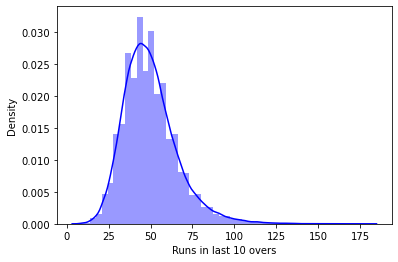

In [30]:
sns.distplot(df['runs_last10'],color = 'blue', axlabel='Runs in last 10 overs')

<AxesSubplot:xlabel='Total Runs', ylabel='Density'>

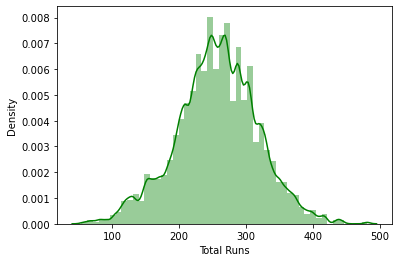

In [31]:
sns.distplot(df['total_runs'], color = 'green', axlabel = 'Total Runs')

<AxesSubplot:xlabel='wickets in last 10 overs', ylabel='Density'>

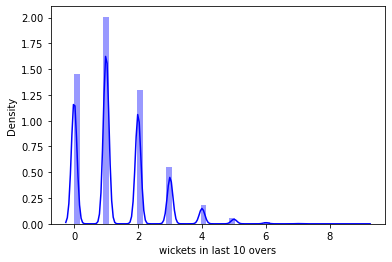

In [33]:
sns.distplot(df['wicket_last10'], color= 'blue', axlabel ='wickets in last 10 overs')

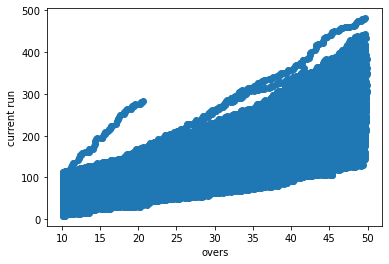

In [36]:
plt.scatter(df['ball'], df['current_run'])
plt.xlabel('overs')
plt.ylabel('current run')
plt.show()

# Dependent and independent features

In [37]:
x = df.iloc[: , [0,1,2,3,4,5,6]].values #Input features
y = df.iloc[: , 7].values #Label

In [39]:
print('x values are: ', x)
print('------------------------------')
print('y values are: ', y)

x values are:  [[ 10.1  47.    1.  ...   0.   43.    1. ]
 [ 10.2  47.    1.  ...   0.   43.    1. ]
 [ 10.3  47.    1.  ...   0.   43.    1. ]
 ...
 [ 44.5 146.    9.  ...   0.   27.    3. ]
 [ 44.6 152.    9.  ...   0.   33.    3. ]
 [ 45.1 152.   10.  ...  55.   33.    3. ]]
------------------------------
y values are:  [229 229 229 ... 152 152 152]


# Split data into training and testing

In [41]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state= 0)

In [42]:
print('Rows and columns for Trainng Independent data: ',x_train.shape) 
print('Rows and columns for Testing Independent data: ',x_test.shape)
print('Rows for Trainng Dependent data: ',y_train.shape) 
print('Rows for Testing Dependent data: ',y_test.shape) 

Rows and columns for Trainng Independent data:  (312598, 7)
Rows and columns for Testing Independent data:  (78150, 7)
Rows for Trainng Dependent data:  (312598,)
Rows for Testing Dependent data:  (78150,)


# Feature scaling

In [24]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test) 

## Multiple Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
param_grid = {'normalize': [True, False]}
cv_lin = GridSearchCV(estimator=lin, param_grid=param_grid, cv= 5)
cv_lin.fit(x_train,y_train)
cv_lin.best_params_

{'normalize': False}

In [10]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression(normalize='False')
lin.fit(x_train,y_train)
print("Linear Regression Train Accuracy: {:.2f} %".format(lin.score(x_train,y_train)*100))
print("Linear Regression Test Accuracy: {:.2f} %".format(lin.score(x_test,y_test)*100))
y_pred = lin.predict(x_test) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Linear Regression Train Accuracy: 61.37 %
Linear Regression Test Accuracy: 61.25 %
RMSE: 37.79095319577014


## Lasso Regression

In [11]:
from sklearn.linear_model import Lasso
lasso_regressor = Lasso()
param_grid = {'alpha': [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40],
              'selection': ['random', 'cyclic'],
              'normalize': [True, False]
            }
cv_lasso_regressor = GridSearchCV(estimator=lasso_regressor, param_grid=param_grid, cv= 5)
cv_lasso_regressor.fit(x_train,y_train)
cv_lasso_regressor.best_params_

{'alpha': 1e-08, 'normalize': True, 'selection': 'random'}

In [11]:
from sklearn.linear_model import Lasso
lasso_regressor = Lasso(alpha=1e-08,normalize='True',selection = 'random')
lasso_regressor.fit(x_train,y_train)
print("Lasso Regression Train Accuracy: {:.2f} %".format(lasso_regressor.score(x_train,y_train)*100))
print("Lasso Regression Test Accuracy: {:.2f} %".format(lasso_regressor.score(x_test,y_test)*100))
y_pred = lasso_regressor.predict(x_test) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Lasso Regression Train Accuracy: 61.37 %
Lasso Regression Test Accuracy: 61.25 %
RMSE: 37.79095324504537


## Ridge Regression

In [25]:
from sklearn.linear_model import Ridge
ridge_regressor = Ridge()
param_grid = {'alpha': [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40],
              'normalize': [True, False]
            }
cv_ridge_regressor = GridSearchCV(estimator=ridge_regressor, param_grid=param_grid, cv= 5)
cv_ridge_regressor.fit(x_train,y_train)
cv_ridge_regressor.best_params_

{'alpha': 0.01, 'normalize': False}

In [26]:
from sklearn.linear_model import Ridge
ridge_regressor = Ridge(alpha=0.01,normalize='False')
ridge_regressor.fit(x_train,y_train)
print("Lasso Regression Train Accuracy: {:.2f} %".format(ridge_regressor.score(x_train,y_train)*100))
print("Lasso Regression Test Accuracy: {:.2f} %".format(ridge_regressor.score(x_test,y_test)*100))
y_pred = ridge_regressor.predict(x_test) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Lasso Regression Train Accuracy: 61.13 %
Lasso Regression Test Accuracy: 61.02 %
RMSE: 37.90542881884737


## K Nearest Neighbors Regression

In [13]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor()
param_grid = {'n_neighbors': [2,5,7]
             }
cv_knn_reg = GridSearchCV(estimator=knn_reg, param_grid=param_grid, cv= 5)
cv_knn_reg.fit(x_train,y_train)
cv_knn_reg.best_params_

{'n_neighbors': 2}

In [27]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor(n_neighbors=2)
knn_reg.fit(x_train,y_train)
print("KNN Regression Train Accuracy: {:.2f} %".format(knn_reg.score(x_train,y_train)*100))
print("KNN Regression Test Accuracy: {:.2f} %".format(knn_reg.score(x_test,y_test)*100))
y_pred = knn_reg.predict(x_test) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

KNN Regression Train Accuracy: 96.97 %
KNN Regression Test Accuracy: 87.43 %
RMSE: 21.52730843916946


## Decision Tree Regression

In [15]:
from sklearn.tree import DecisionTreeRegressor
des_tree = DecisionTreeRegressor()
param_grid = {'criterion' : ['mse','friedman_mse'],
              'splitter': ['best','random']
             }
cv_des_tree = GridSearchCV(estimator=des_tree, param_grid=param_grid, cv= 5)
cv_des_tree.fit(x_train,y_train)
cv_des_tree.best_params_

{'criterion': 'mse', 'splitter': 'best'}

In [13]:
from sklearn.tree import DecisionTreeRegressor
des_tree = DecisionTreeRegressor(criterion='mse', splitter='best')
des_tree.fit(x_train,y_train)
print("DecisionTree Regression Train Accuracy: {:.2f} %".format(des_tree.score(x_train,y_train)*100))
print("DecisionTree Regression Test Accuracy: {:.2f} %".format(des_tree.score(x_test,y_test)*100))
y_pred = des_tree.predict(x_test) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

DecisionTree Regression Train Accuracy: 100.00 %
DecisionTree Regression Test Accuracy: 72.07 %
RMSE: 32.08568700361471


## Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor()
param_grid = {'n_estimators': [100,200],
              'criterion': ['mse','mae']
             }
cv_random_forest = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv= 5)
cv_random_forest.fit(x_train,y_train)
cv_random_forest.best_params_

In [14]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(x_train,y_train)
print("RandomForest Regression Train Accuracy: {:.2f} %".format(random_forest.score(x_train,y_train)*100))
print("RandomForest Regression Test Accuracy: {:.2f} %".format(random_forest.score(x_test,y_test)*100))
y_pred = random_forest.predict(x_test) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RandomForest Regression Train Accuracy: 98.10 %
RandomForest Regression Test Accuracy: 86.47 %
RMSE: 22.333041949380394


# Cross Validation of best performing algorithms

In [46]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(random_forest, x, y, cv=cv)

array([0.86622789, 0.86691576, 0.86609772, 0.86552657, 0.86726615])

In [45]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(knn_reg, x, y, cv=cv)

array([0.84580976, 0.84569547, 0.84962481, 0.84581611, 0.84497079])

# Predict total score

In [ ]:
y_pred_random = lin_random.predict(x_test) 
y_pred_random

In [53]:
print('Actual values are ',y_test)
print('-----------------------------')
print('Predicted values are ',y_pred)

Actual values are  [208 308 252 ... 226 225 359]
-----------------------------
Predicted values are  [208.  288.5 264.  ... 226.  185.5 359. ]


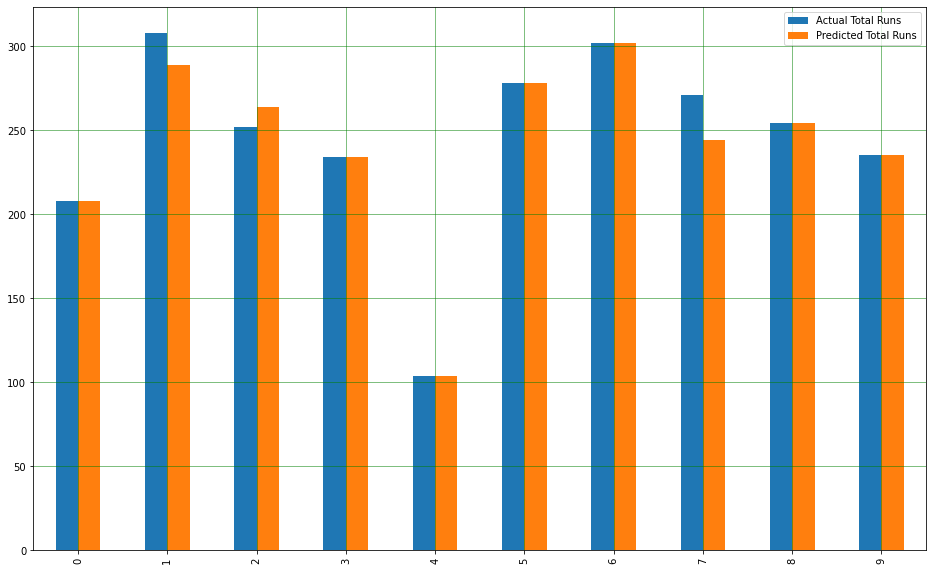

In [60]:
df1 = pd.DataFrame({'Actual Total Runs': y_test, 'Predicted Total Runs': y_pred})
df1 = df1.head(10)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [62]:
run_prediction = knn_reg.predict(sc.transform(np.array([[29.5,211,3,51,29,76,2]])))
print("Predicted runs after 50 overs:" , run_prediction)

Predicted runs after 50 overs: [353.5]


In [31]:
run_prediction = knn_reg.predict(sc.transform(np.array([[24,101,3,22,3,50,2]])))
print("Predicted runs after 50 overs:" , run_prediction)

Predicted runs after 50 overs: [246.]


# Model deployment

In [ ]:
pickle.dump(knn_reg, open('model.pkl', 'wb'))